In [17]:
import lhires_pipe as lp
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits

print("LOADED")

LOADED


In [3]:

# --- Setup ---
data_dir = 'C:/Users/navar/Downloads/Zeiss/zeiss_etacar/'  # Your root data directory
output_dir = 'C:/Users/navar/Downloads/Zeiss/zeiss_etacar/processed/'

file_extension = '.fit'

bias_prefix = 'bias_'
flat_prefix = 'dflat_300s_'
arc_prefix = 'hear_300s_'
sci_prefix = 'etaCar_300s_'
std_prefix = 'HIP54830_600s_'

fileout_bias = 'master_bias'
fileout_flat = 'master_flat'
fileout_norm_flat = 'master_norm_flat'

sci_name = 'eta Carinae' # will query simbad to search for RA and Dec
std_name = 'HIP54830'    # will query simbad to search for RA and Dec


#########################################################################
# Lines used for wavelength solution - in general, do not modify 'HeAr_peak_wavelengths'
#  but make sure to check if the corresponding pixel position is within +/-5 pixels from the values provided in 'HeAr_peak_pixels'
HeAr_peak_wavelengths = np.array([4545.052, 4579.39, 4657.901, 4713.143, 4764.865, 4806.0205, 4879.90, 4921.931, 4965.12, 5015.678]) # in Angstrom
HeAr_peak_pixels      = np.array([       5,     195,      629,      937,   1224,        1453,    1866,   2100,      2343,     2626]) # in pixel

#############################################
# default values (No need to modify)
#
# measure wavelength solution for every 'n_pix_step' pixels in the spatial direction to correct for distortion
n_pix_step = 10
# polynomial order to fit spatial distortion
ndeg_distortion = 2
# polynomial order to fit wavelength solution
ndeg_wavesolution = 3
#
save_plots = True
figsize = (15,5)
fontsize = 12
plot_extension = '.png'
#
os.makedirs(output_dir, exist_ok=True)

print("DONE")

DONE


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


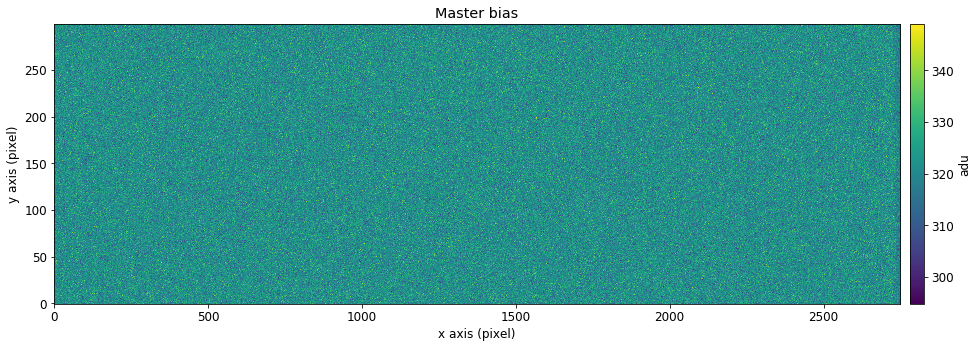

In [6]:

# step #1 - combine bias frames

# load frames
bias_frames = lp.load_fits_data(data_dir, bias_prefix)

# combine with average and sigma clipping method
master_bias = lp.process_frames(bias_frames, bias=None, flat=None, sigma_clip=5, scale=None)

# save master bias
master_bias.write(os.path.join(output_dir, fileout_bias + file_extension), overwrite=True)

# display master bias
lp.plot_data(master_bias, percent_display=None, title='Master bias', xlabel='x axis (pixel)', ylabel='y axis (pixel)',
             colorscale_label='adu', figsize=figsize, fontsize=fontsize, output=os.path.join(output_dir, fileout_bias + plot_extension))

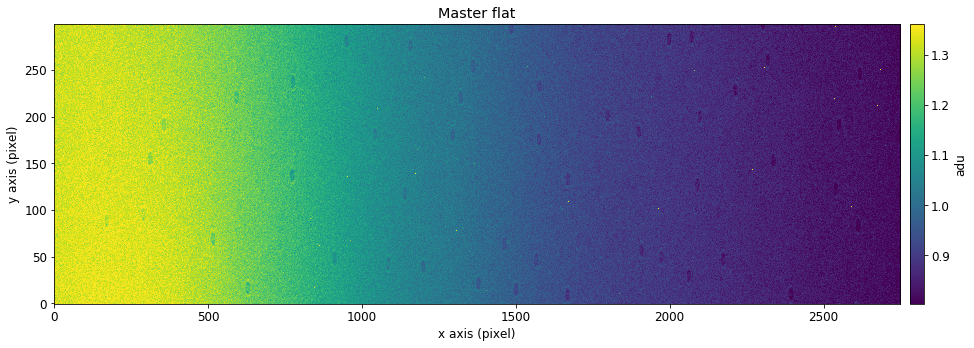

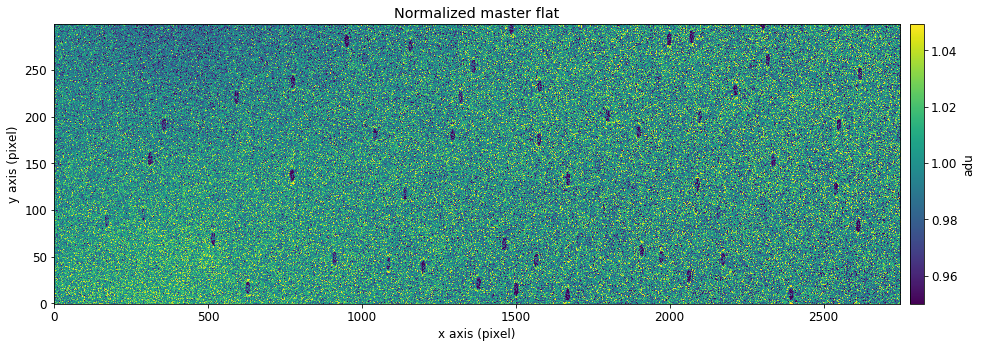

In [8]:
# --- Step 2: Combine Flat, Bias Subtraction and Normalization ---
flat_frames  = lp.load_fits_data(data_dir, flat_prefix, return_file_names=False)

# combine with average and sigma clipping method, using the inverse of the median as scaling for combining the flat field frames
master_flat = lp.process_frames(flat_frames, bias=master_bias, flat=None, sigma_clip=5, scale=lp.inv_median)

# save master flat
master_flat.write(os.path.join(output_dir, fileout_flat + file_extension), overwrite=True)

# display master flat
lp.plot_data(master_flat, percent_display=[1,99], title='Master flat', xlabel='x axis (pixel)', ylabel='y axis (pixel)',
          colorscale_label='adu', figsize=figsize, fontsize=fontsize, output=os.path.join(output_dir, fileout_flat + plot_extension))

# Normalize flat (along dispersion axis)
flat_norm = master_flat.data / np.median(master_flat.data, axis=0)
master_norm_flat = master_flat.copy()
master_norm_flat.data = flat_norm
master_norm_flat.write(os.path.join(output_dir,  fileout_norm_flat + file_extension), overwrite=True)
lp.plot_data(master_norm_flat, percent_display=[1,99], title='Normalized master flat', xlabel='x axis (pixel)', ylabel='y axis (pixel)',
          colorscale_label='adu', figsize=figsize, fontsize=fontsize, output=os.path.join(output_dir, fileout_norm_flat + plot_extension))

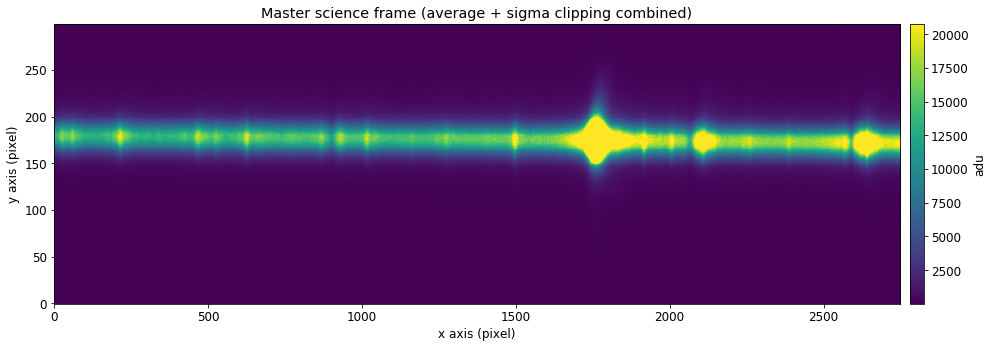

In [9]:
# --- Step 3: Reduce Science Frames ---
science_frames, science_files = lp.load_fits_data(data_dir, sci_prefix, return_file_names=True)

# combine with average and sigma clipping method
master_sci = lp.process_frames(science_frames, bias=master_bias, flat=master_norm_flat, sigma_clip=5, scale=None)

# define the file name for the master science frame
fileout_sci = science_files[0].split(file_extension)[0]

prefix = 'cfb_' # c-combined; f- flat-field correction; b-bias subtraction

# save the master science frame
master_sci.write(os.path.join(output_dir, prefix + fileout_sci + file_extension), overwrite=True)
# plot the master science frame
lp.plot_data(master_sci, percent_display=[1,99], title='Master science frame (average + sigma clipping combined)', xlabel='x axis (pixel)', ylabel='y axis (pixel)',
          colorscale_label='adu', figsize=figsize, fontsize=fontsize, output=os.path.join(output_dir, prefix + fileout_sci + plot_extension))

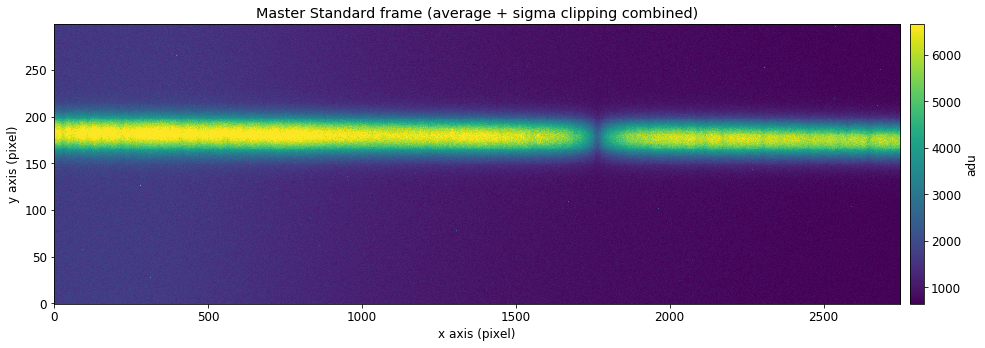

In [10]:
# --- Step 4: Reduce Standard Star Frames ---
std_frames, std_files = lp.load_fits_data(data_dir, 'HIP54830_', return_file_names=True)

# combine with average and sigma clipping method
master_std = lp.process_frames(std_frames, bias=master_bias, flat=master_norm_flat, sigma_clip=5, scale=None)

# define the file name for the master Standard frame
fileout_std = std_files[0].split(file_extension)[0]

# save the master science frame
master_std.write(os.path.join(output_dir, prefix + fileout_std + file_extension), overwrite=True)

# plot the master science frame
lp.plot_data(master_std, percent_display=[1,99], title='Master Standard frame (average + sigma clipping combined)', xlabel='x axis (pixel)', ylabel='y axis (pixel)',
          colorscale_label='adu', figsize=figsize, fontsize=fontsize, output=os.path.join(output_dir, prefix + fileout_std + plot_extension))

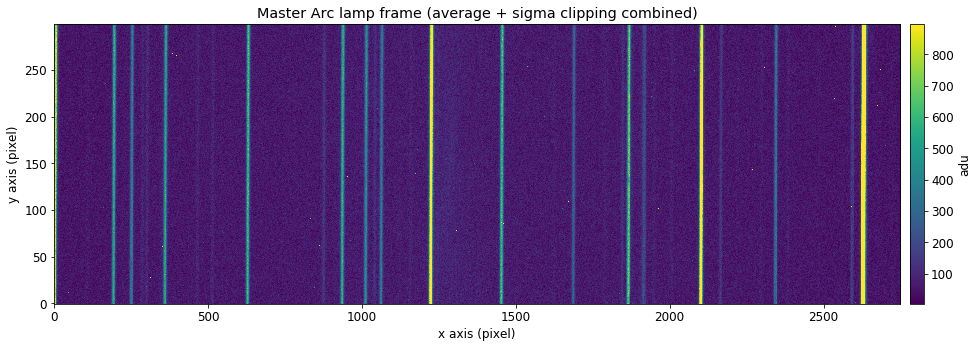

In [11]:
# --- Step 5: Reduce Arc Frames ---
arc_frames, arc_files = lp.load_fits_data(data_dir, 'hear_', return_file_names=True)

# combine with average and sigma clipping method
master_arc = lp.process_frames(arc_frames, bias=master_bias, flat=master_norm_flat, sigma_clip=5, scale=None)

# define the file name for the master science frame
fileout_arc = arc_files[0].split(file_extension)[0]

# save master arc frame
master_arc.write(os.path.join(output_dir, prefix + fileout_arc + file_extension), overwrite=True)

# plot the master science frame
lp.plot_data(master_arc, percent_display=[1,99], title='Master Arc lamp frame (average + sigma clipping combined)', xlabel='x axis (pixel)', ylabel='y axis (pixel)',
          colorscale_label='adu', figsize=figsize, fontsize=fontsize, output=os.path.join(output_dir, prefix + fileout_arc + plot_extension))

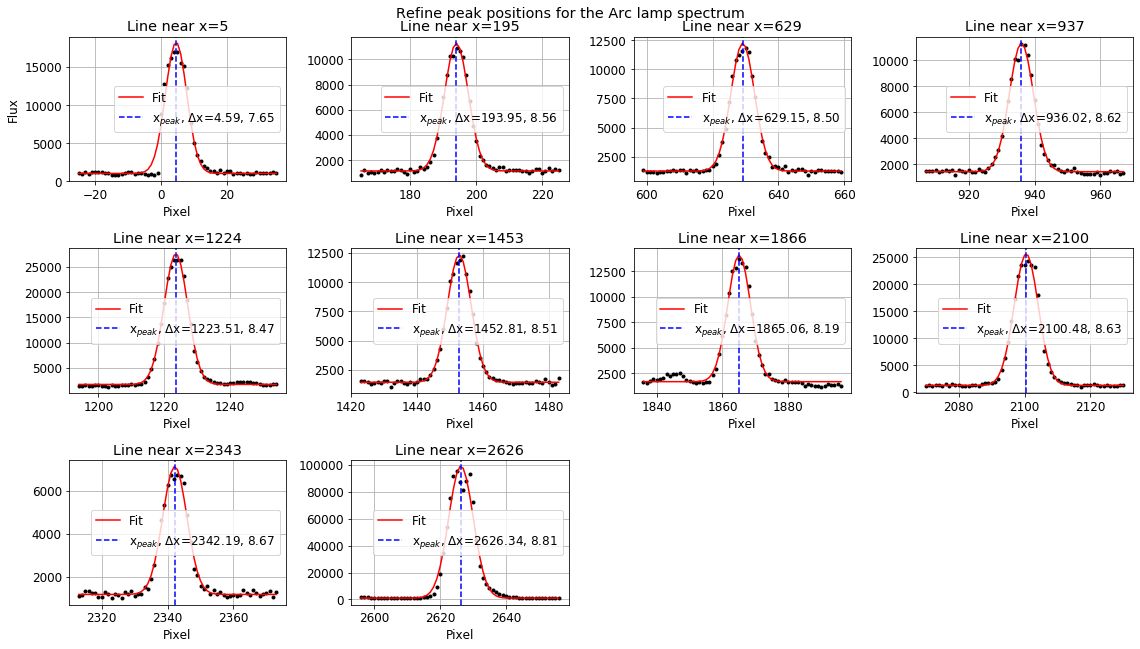

In [12]:

# step 6 perform wavelength calibration

# 6.1. use input wavelength information (HeAr_peak_wavelengths, HeAr_peak_pixels) to refine peak positions for the HeAr lamp

# get center and range on y axis (along slit)
y_ref   = int(0.5 * master_arc.shape[0])
y_range = (y_ref - 10, y_ref + 10 )

# extract the arc at the reference position
arc_1d = lp.extract_1d_arc_spectrum(master_arc, row_range=y_range)

# refine center positions for the HeAr lines used for wavelength calibration
HeAr_peak_pixels_refined = lp.refine_arc_peak_positions(arc_1d, HeAr_peak_pixels, window=30, plot_fits=True, n_col=4,
                                                        output=os.path.join(output_dir, fileout_arc + "_peak_positions" + plot_extension))


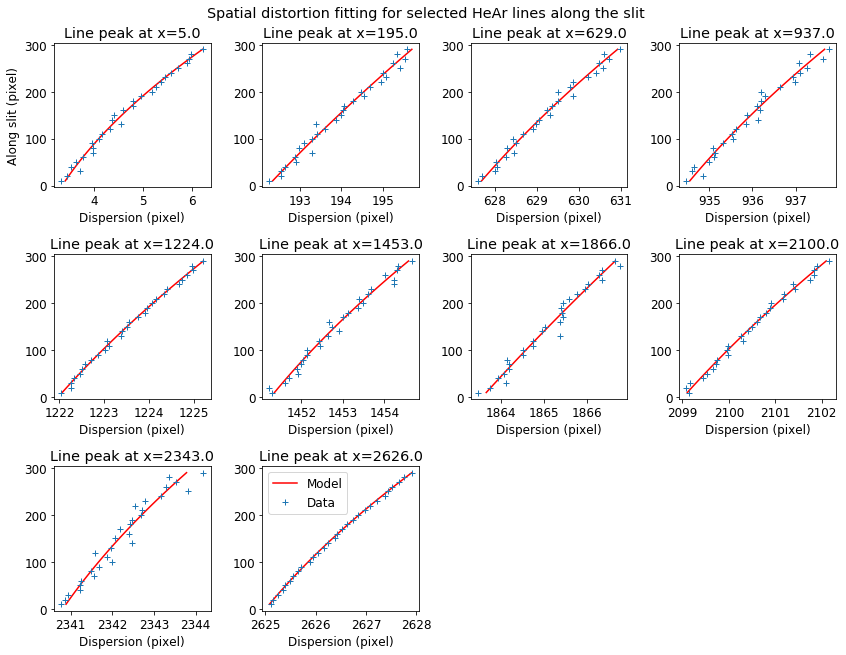

In [13]:
# 6.2 map spatial distortion along the slit
#     measure the distortion of the lines along the slit, and construct a grid of y axis for interpolation
spat_rows, polyfits_x_along_y = lp.fit_spatial_distortion(master_arc, HeAr_peak_pixels, n_pix_step=n_pix_step, ndeg=ndeg_distortion, n_col=4, 
                                                          output=os.path.join(output_dir, fileout_arc + "_spatial_distortion" + plot_extension))


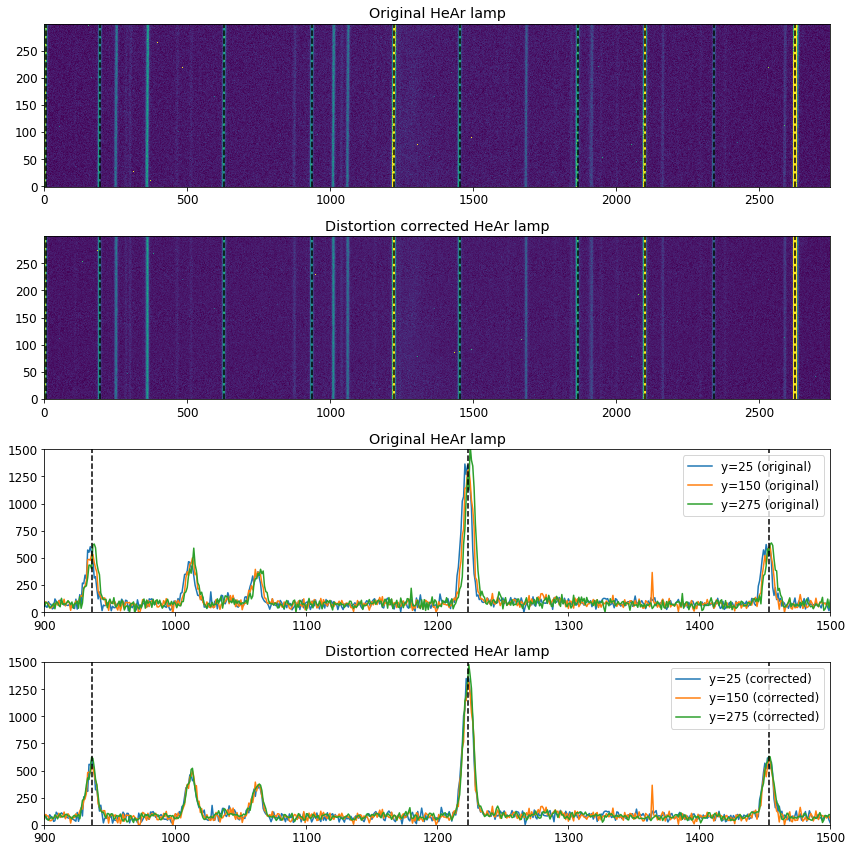

In [14]:
# 6.3 apply spatial distortion correction, plot the arc lamp to show the results.

prefix = 'tcfb_'

arc = lp.correct_spatial_distortion(master_arc, spat_rows, polyfits_x_along_y[:,0], HeAr_peak_pixels_refined, y_ref=None, show_plot=True, figsize=(12,12),
                                    output=os.path.join(output_dir, fileout_arc + "_correct_spatial_distortion" + plot_extension))
arc.write(os.path.join(output_dir, prefix + fileout_arc + file_extension), overwrite=True)

sci = lp.correct_spatial_distortion(master_sci, spat_rows, polyfits_x_along_y[:,0], HeAr_peak_pixels_refined, y_ref=None, show_plot=False, output=None)
sci.write(os.path.join(output_dir, prefix + fileout_sci + file_extension), overwrite=True)

std = lp.correct_spatial_distortion(master_std, spat_rows, polyfits_x_along_y[:,0], HeAr_peak_pixels_refined, y_ref=None, show_plot=False, output=None)
std.write(os.path.join(output_dir, prefix + fileout_std + file_extension), overwrite=True)



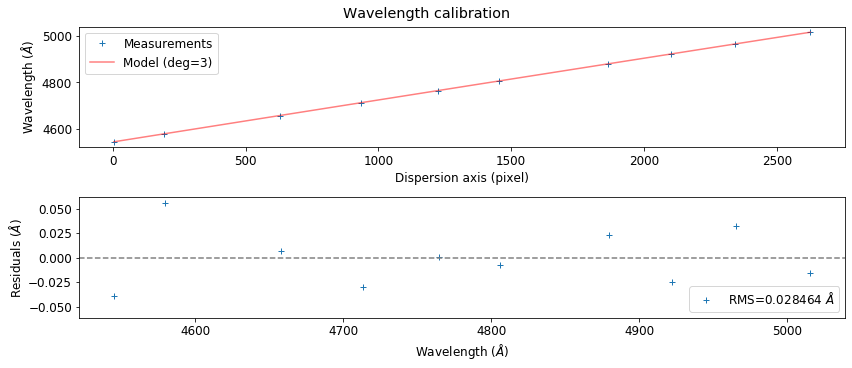

In [15]:
# 7. wavelength calibration
fit_wavelength, rms_wavesol = lp.wavelength_calibration(HeAr_peak_pixels_refined, HeAr_peak_wavelengths, ndeg=ndeg_wavesolution, show_plot=True, figsize=(12,5),
                                                        output=os.path.join(output_dir, fileout_arc + "_wavelength_solution" + plot_extension))


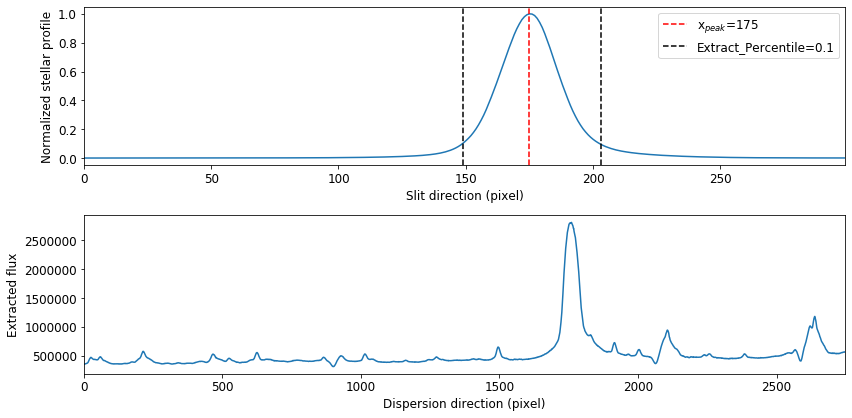

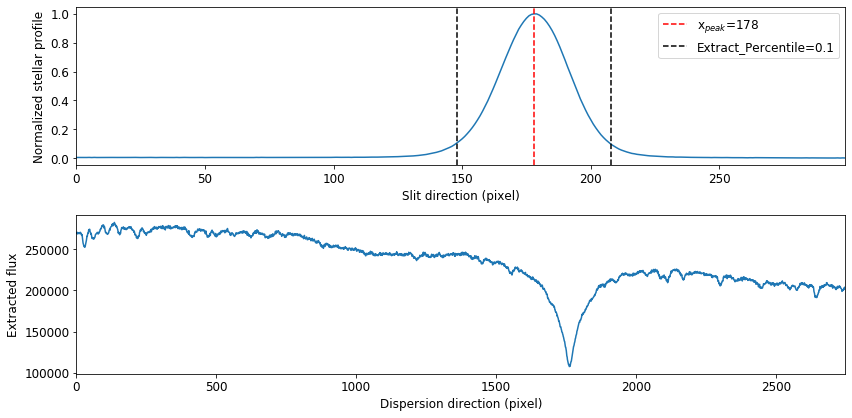

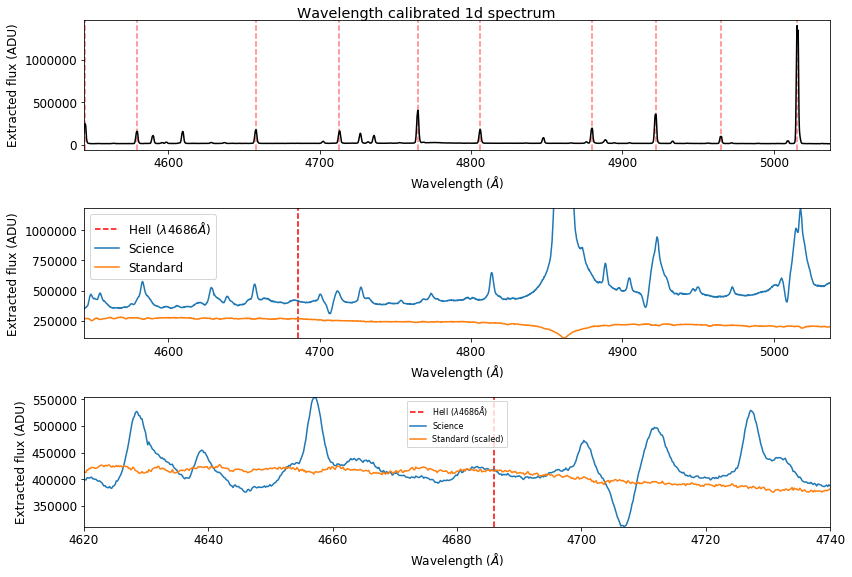

In [18]:
# now extract the data
prefix = 'xtcfb_'

arc_spectrum = lp.extract_spectrum_1d(arc, extract_percentile=None, show_plot=False, figsize=(12,4), output=None)
sci_spectrum = lp.extract_spectrum_1d(sci, extract_percentile=0.1, show_plot=True, figsize=(12,6), 
                                      output=os.path.join(output_dir, prefix + fileout_sci + plot_extension))
std_spectrum = lp.extract_spectrum_1d(std, extract_percentile=0.1, show_plot=True, figsize=(12,6), 
                                      output=os.path.join(output_dir, prefix + fileout_std + plot_extension))

x_axis = np.arange(len(sci_spectrum.data))
wavelength_axis = fit_wavelength(x_axis)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
for wave in HeAr_peak_wavelengths:
    plt.axvline(wave,ls='--', color='red', alpha=0.5)
plt.plot(wavelength_axis, arc_spectrum.data, color='black')
plt.ylabel(r'Extracted flux (ADU)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.xlim(np.min(wavelength_axis),np.max(wavelength_axis))

plt.subplot(3,1,2)
xlim = (4800,4900)
xlw = (wavelength_axis < xlim[0]) ^ (wavelength_axis > xlim[1])
y_sci = sci_spectrum.data[xlw]
y_std = std_spectrum.data
ymin = np.nanmin([np.nanmin(y_std),np.nanmin(y_sci)])
ymax = np.nanmax([np.nanmax(y_std),np.nanmax(y_sci)])
ylim = (ymin,ymax)

plt.axvline(4686,ls='--', color='red', label=r"HeII ($\lambda$4686$\AA$)")
plt.plot(wavelength_axis, sci_spectrum.data, label='Science')
plt.plot(wavelength_axis, std_spectrum.data, label='Standard')
plt.ylabel(r'Extracted flux (ADU)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.xlim(np.min(wavelength_axis),np.max(wavelength_axis))
plt.ylim(ylim)
plt.legend()

plt.subplot(3,1,3)
plt.axvline(4686,ls='--', color='red', label=r"HeII ($\lambda$4686$\AA$)")

xlim = (4620,4740)
xlw = (wavelength_axis > xlim[0]) * (wavelength_axis < xlim[1])
y_sci = sci_spectrum.data[xlw]
y_std = std_spectrum.data[xlw]
ylim = (np.nanmin(y_sci),np.nanmax(y_sci))

plt.plot(wavelength_axis, sci_spectrum.data, label='Science')
plt.plot(wavelength_axis, std_spectrum.data * np.median(y_sci) / np.median(y_std), label='Standard (scaled)')
plt.ylabel(r'Extracted flux (ADU)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(fontsize=8)
plt.suptitle("Wavelength calibrated 1d spectrum", y=1.0)
plt.tight_layout()
output=os.path.join(output_dir, fileout_sci + "_wavelength_calibrated_1d" + plot_extension)
plt.savefig(output, dpi=300)
plt.show()

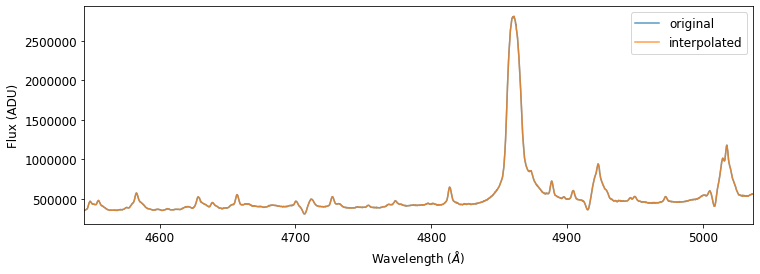

In [19]:
# now interpolate the wavelength solution into a linear grid
sci_interp, wave_linear = lp.interpolate_wavelength_axis(sci_spectrum,wavelength_axis, dispersion=None, show_plot=True, figsize=(12,4))
std_interp, _           = lp.interpolate_wavelength_axis(std_spectrum,wavelength_axis, dispersion=None, show_plot=False, figsize=(12,4))
arc_interp, _           = lp.interpolate_wavelength_axis(arc_spectrum,wavelength_axis, dispersion=None, show_plot=False, figsize=(12,4))

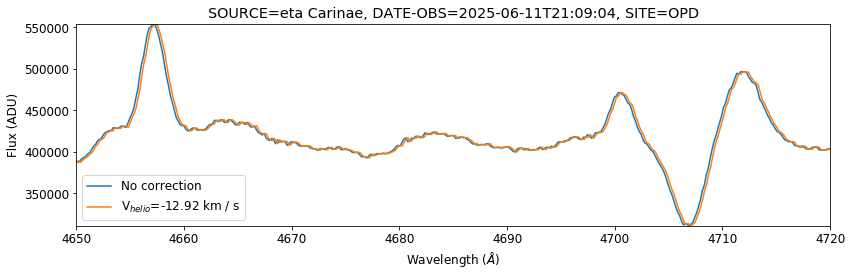

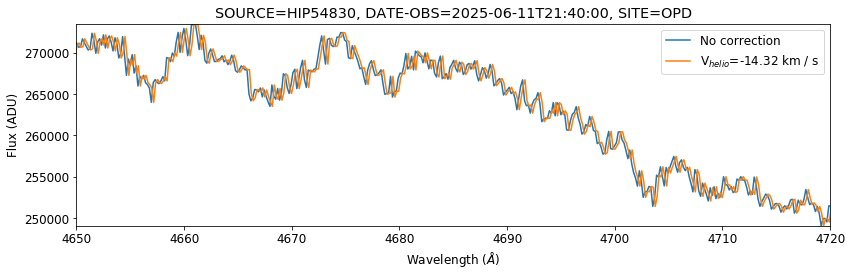

Saved: C:/Users/navar/Downloads/Zeiss/zeiss_etacar/processed/wxtcfb_hear_300s_118.fit
Saved: C:/Users/navar/Downloads/Zeiss/zeiss_etacar/processed/hwxtcfb_HIP54830_600s_117.fit
Saved: C:/Users/navar/Downloads/Zeiss/zeiss_etacar/processed/hwxtcfb_etaCar_300s_114.fit


In [20]:
# Heliocentric velocity correction

sci_dateobs = sci_interp.header['DATE-OBS']

sci_vhelio_corrected, vhelio = lp.heliocentric_correction(sci_name, sci_dateobs, sci_interp, ra=None, dec=None, show_plot=True, wave_range=(4650,4720), figsize=(12,4), 
                                             output=os.path.join(output_dir, fileout_sci + "_heliocentric_correction" + plot_extension))


std_dateobs = std_interp.header['DATE-OBS']

std_vhelio_corrected, std_vhelio = lp.heliocentric_correction(std_name, std_dateobs, std_interp, ra=None, dec=None, show_plot=True, wave_range=(4650,4720), figsize=(12,4), 
                                             output=os.path.join(output_dir, fileout_std + "_heliocentric_correction" + plot_extension))


# now save calibrated 1d spectrum:
prefix = 'wxtcfb_'
lp.save_spectrum_to_fits(arc_interp,           os.path.join(output_dir,       prefix + fileout_arc + file_extension))
lp.save_spectrum_to_fits(sci_vhelio_corrected, os.path.join(output_dir, 'h' + prefix + fileout_std + file_extension))
lp.save_spectrum_to_fits(std_vhelio_corrected, os.path.join(output_dir, 'h' + prefix + fileout_sci + file_extension))